In [9]:
import os
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML, Image
from base64 import b64encode

%matplotlib inline

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)
URL = r"https://www.dropbox.com/s/089r2yg6aao858l/opencv_bootcamp_assets_NB14.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB14.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)   

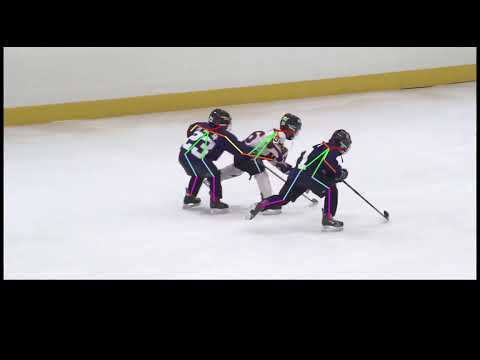

In [4]:
video = YouTubeVideo("RyCsSc_2ZEI", width=1024, height=640)
display(video)

In [ ]:
protoFile = "Models/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "Models/pose_iter_160000.caffemodel"
# The model defined by protoFile and weightsFile is a deep neural network for human pose estimation.
# It uses a multi-stage CNN architecture (OpenPose) to detect body keypoints in an image.
# The prototxt file (protoFile) describes the network architecture (layers, connections, etc.).
# The caffemodel file (weightsFile) contains the pre-trained weights for the network.
# The model takes an input image, processes it through several convolutional layers,
# and outputs confidence maps for each keypoint (e.g., nose, elbows, knees).
# keypoints are the important points on a human body that the model is trained to detect,
# confidence maps is a 2D grid where each pixel corresponds to a location in the input image.
# Each confidence map indicates the probability of a keypoint being present at each pixel location.
# The network also predicts part affinity fields, which help associate detected keypoints into skeletons.
# By finding the maxima in these confidence maps and associating them using the affinity fields,
# the model can estimate the pose (skeleton) of the person in the image.

In [6]:
nPoints = 15 
# This is used to draw the skeleton.

POSE_PAIRS = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [1, 5],
    [5, 6],
    [6, 7],
    [1, 14],
    [14, 8],
    [8, 9],
    [9, 10],
    [14, 11],
    [11, 12],
    [12, 13],
]
# This is used to draw the skeleton connections.

net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)

In [22]:
im = cv.imread("Photos/Tiger_Woods.png")
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

inWidth = im.shape[1]
inHeight = im.shape[0]

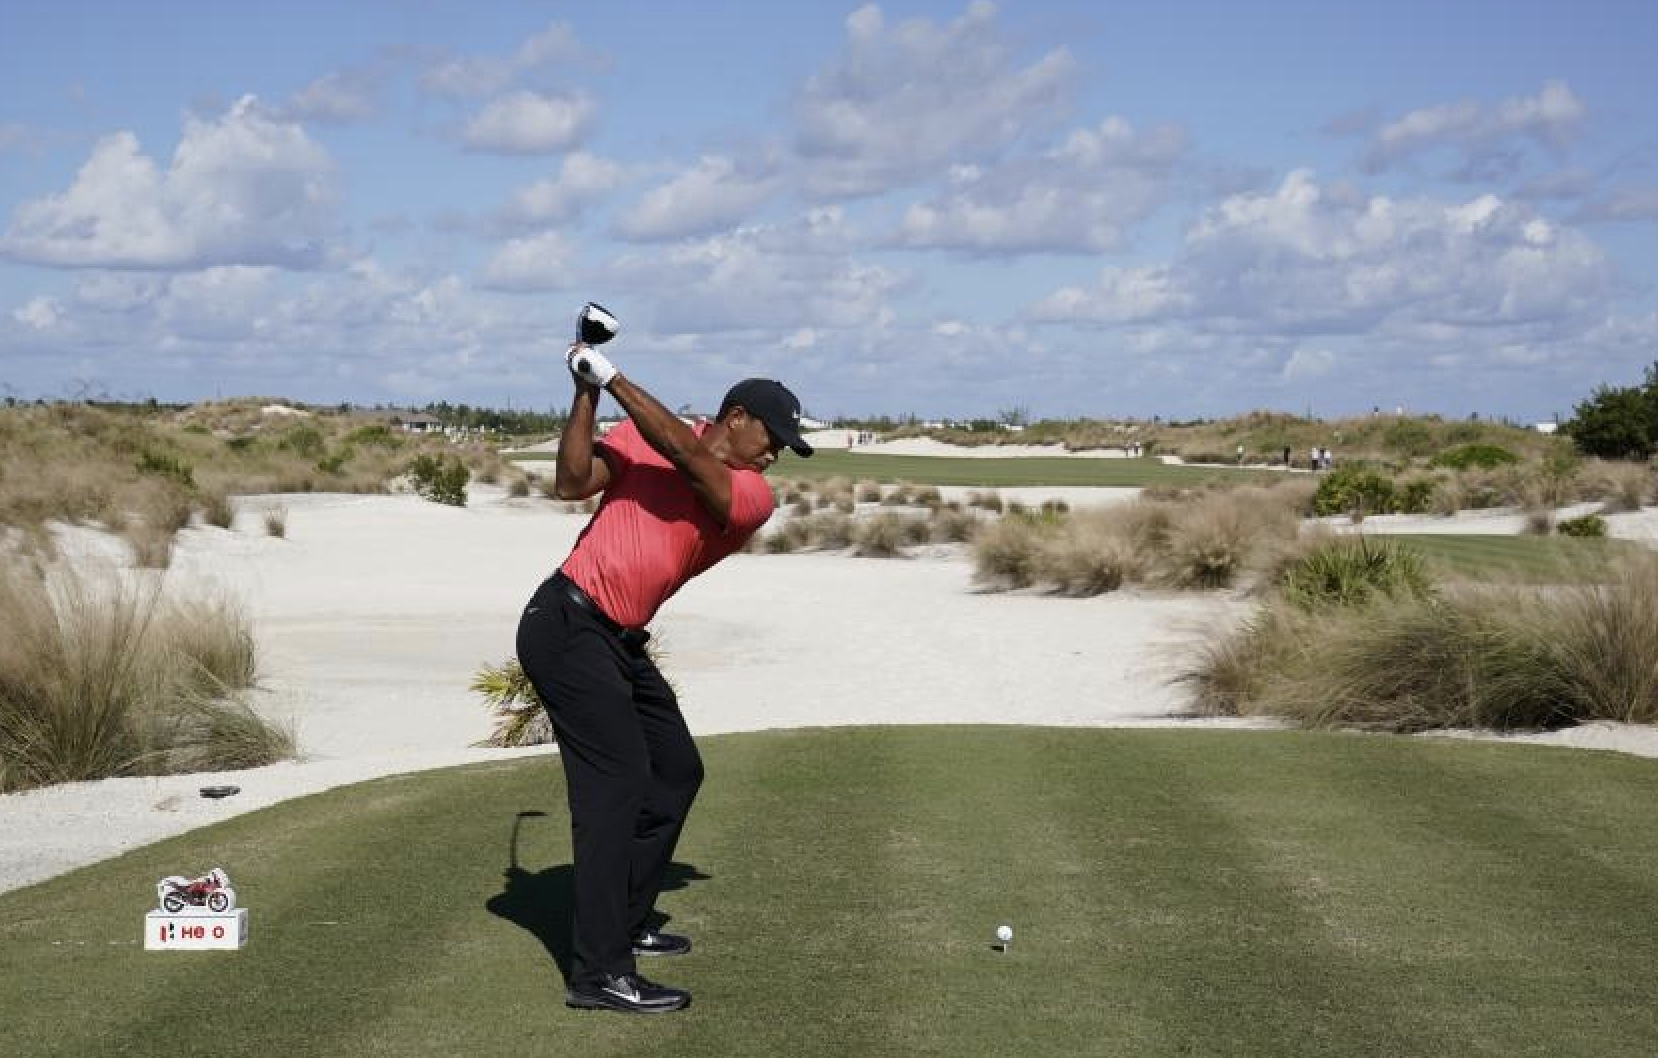

In [23]:
Image(filename="Photos/Tiger_Woods.png")

In [13]:
netInputSize = (368, 368)
inpBlob = cv.dnn.blobFromImage(im, 1.0 / 255, netInputSize, (0, 0, 0), swapRB=True, crop=False)
# Blob is a 4-dimensional array with dimensions (1, 3, height, width).
# Used to prepare the input image for the neural network.
# Parameters:
# - First parameter is the input image.
# - Second parameter is the scale factor (Used to normalize the image).
# - Third parameter is the size of the input image.
# - Fourth parameter is the mean subtraction value.
net.setInput(inpBlob)
output = net.forward()

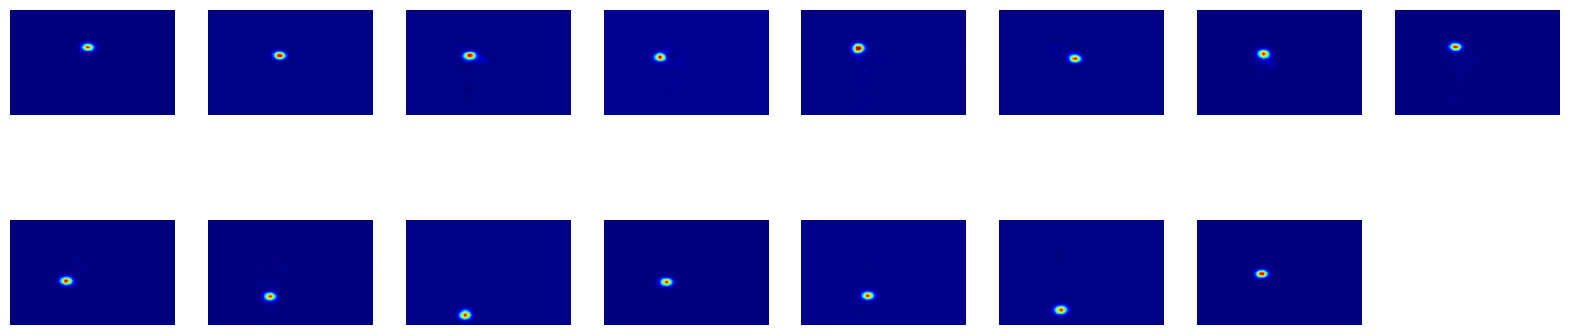

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(nPoints):
    probMap = output[0, i, :, :]
    # probMap is a 2D array with the probability of the keypoint being present at each pixel.
    displayMap = cv.resize(probMap, (inWidth, inHeight), cv.INTER_LINEAR)
    plt.subplot(2, 8, i + 1)
    plt.axis("off")
    plt.imshow(displayMap, cmap="jet")

In [15]:
scaleX = inWidth / output.shape[3] # Scale factor for width.
scaleY = inHeight / output.shape[2] # Scale factor for height.

points = []
threshold = 0.1 # Confidence threshold.

for i in range(nPoints):
    # Get the confidence map for the current point.
    probMap = output[0, i, :, :]
    # Get the location of the maximum value in the confidence map.
    minVal, prob, minLoc, point = cv.minMaxLoc(probMap)
    # minMaxLoc returns the minimum and maximum values and their locations in the confidence map.
    # point is a tuple (x, y) representing the location of the maximum value in the confidence map.
    # prob is the confidence value of the maximum value in the confidence map.
    # minVal is the minimum value in the confidence map.
    # minLoc is the location of the minimum value in the confidence map.
    
    # Scale the point coordinates to the original image size.
    x = int(point[0] * scaleX)
    y = int(point[1] * scaleY)

    if prob > threshold:
        points.append((x, y))
    else:
        points.append(None)
# This loop iterates over all the keypoints and checks if the confidence value is above the threshold.
# useful for filtering out low-confidence keypoints.

In [18]:
imPoints = im.copy()
imSkeleton = im.copy()

for i, p in enumerate(points):
    if p is not None:
        cv.circle(imPoints, p, 8, (0, 255, 0), thickness=-1, lineType=cv.FILLED)
        cv.putText(imPoints, str(i), (p[0] + 5, p[1] - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=2)
# This loop iterates over all the keypoints and draws a circle at the location of each keypoint.
# It also adds a label (index) to each keypoint.

for pair in POSE_PAIRS:
    partA, partB = pair
    
    if points[partA] and points[partB]:
        cv.line(imSkeleton, points[partA], points[partB], (0, 255, 0), 2)
        cv.circle(imSkeleton, points[partA], 8, (0, 255, 0), thickness=-1, lineType=cv.FILLED)
        # This circle is drawn at the location of the first keypoint in the pair because it is the start of the line.
# This loop iterates over all the pairs of keypoints and draws a line between them.

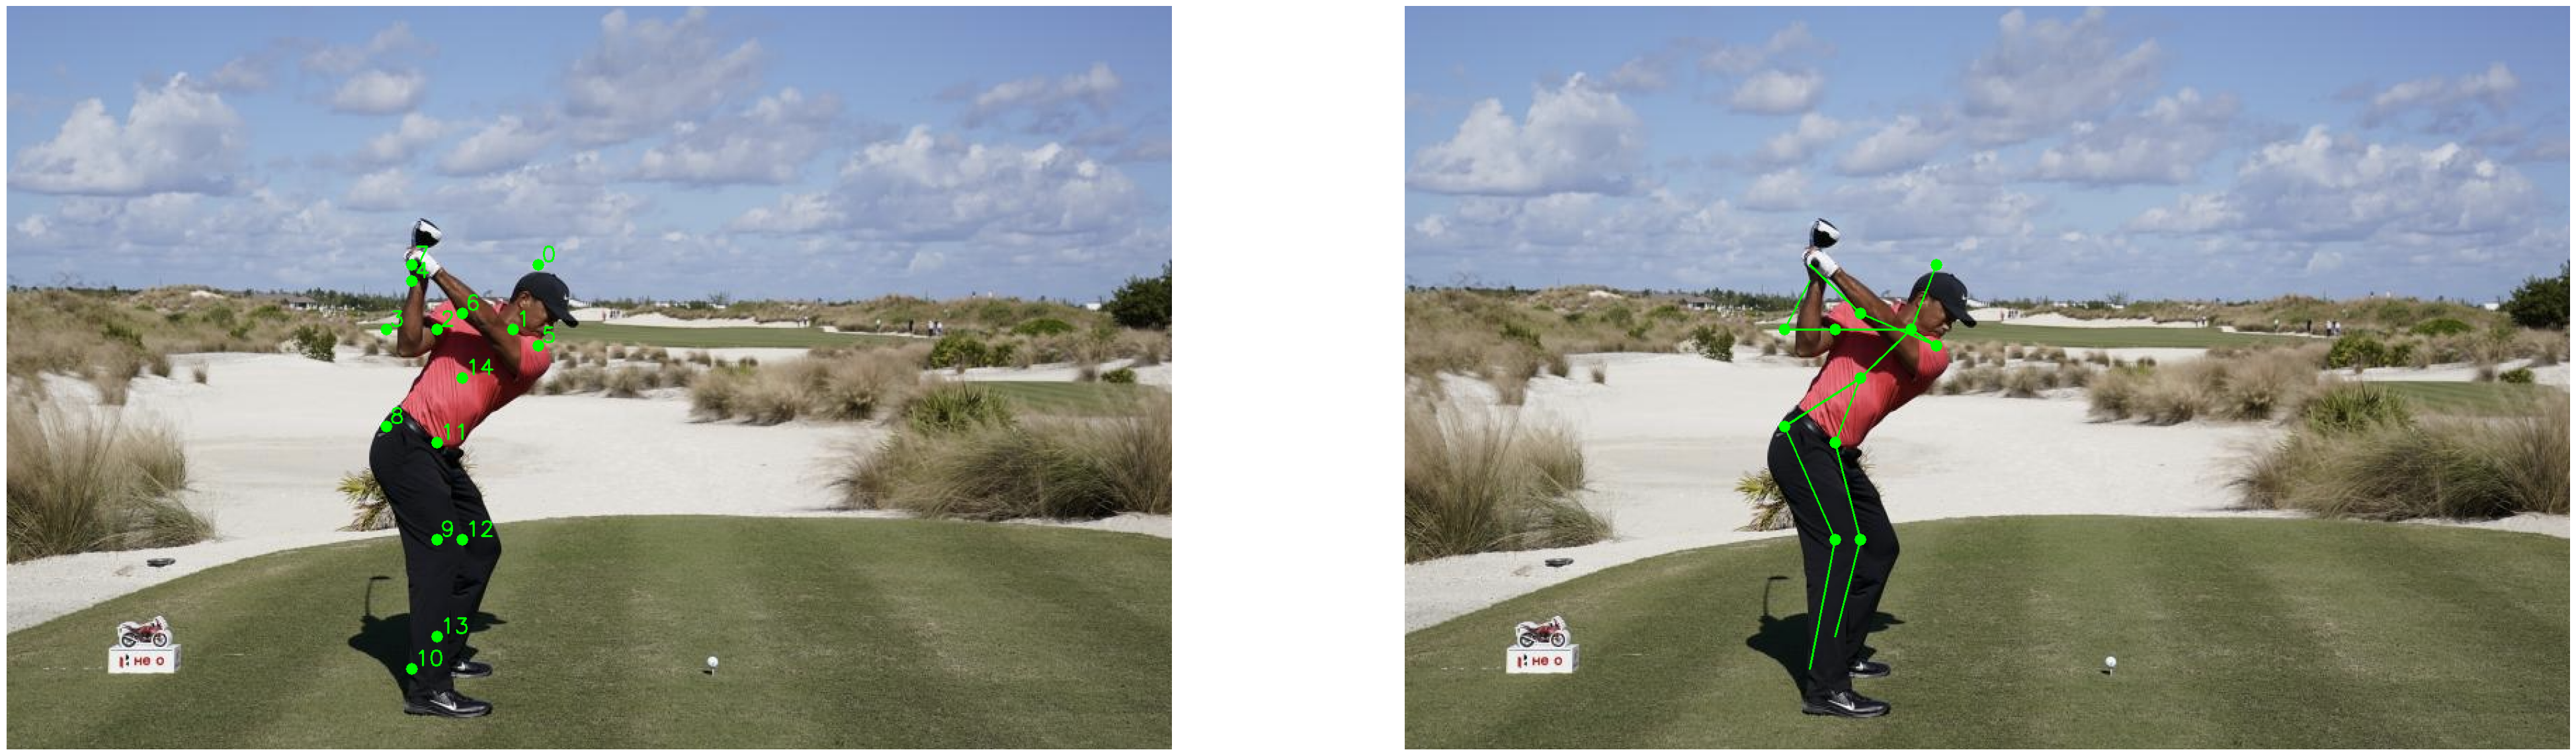

In [19]:
plt.figure(figsize=(50, 50))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(imPoints)    
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(imSkeleton)
plt.show()